In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

"""
Assignment 4: Data Visualization Analysis
Research Question: Does higher renewable energy adoption correlate with lower per capita CO2 emissions across countries?

Datasets:
1. Our World in Data - Renewable Energy: https://ourworldindata.org/renewable-energy
2. Our World in Data - CO2 Emissions: https://ourworldindata.org/co2-emissions

This analysis incorporates Tufte's high data-ink ratio principle and Cairo's principles of truth, beauty, function, and insight.
"""

# Load datasets
renewable_df = pd.read_csv("assets/renewable-share-energy.csv")
co2_df = pd.read_csv("assets/co2-fossil-plus-land-use.csv")

# Clean column names
renewable_df.columns = renewable_df.columns.str.strip()
co2_df.columns = co2_df.columns.str.strip()

# Remove non-ASCII characters from columns (to fix weird encoding issues)
renewable_df.columns = renewable_df.columns.str.encode('ascii', 'ignore').str.decode('ascii')
co2_df.columns = co2_df.columns.str.encode('ascii', 'ignore').str.decode('ascii')

# Rename columns for consistency
renewable_df = renewable_df.rename(columns={
    'Entity': 'Country',
    'Year': 'Year',
    'Renewables (% equivalent primary energy)': 'Renewable_Percent'
})

co2_df = co2_df.rename(columns={
    'Entity': 'Country',
    'Year': 'Year',
    'Annual CO emissions': 'Total_CO2'  # Use total CO2 including land use
})

# Convert relevant columns to numeric (handle parsing issues)
renewable_df['Renewable_Percent'] = pd.to_numeric(renewable_df['Renewable_Percent'], errors='coerce')
co2_df['Total_CO2'] = pd.to_numeric(co2_df['Total_CO2'], errors='coerce')

# === COUNTRY-LEVEL DATA PREPARATION ===

# Use latest common year available in both datasets
latest_common_year = min(renewable_df['Year'].max(), co2_df['Year'].max())
renewable_latest = renewable_df[renewable_df['Year'] == latest_common_year]
co2_latest = co2_df[co2_df['Year'] == latest_common_year]

# Merge country data on latest year
df = pd.merge(
    renewable_latest[['Country', 'Renewable_Percent']],
    co2_latest[['Country', 'Total_CO2']],
    on='Country',
    how='inner'
)

# Define countries of interest and their populations (in millions)
countries_of_interest = [
    'Norway', 'Iceland', 'Sweden', 'Finland', 'Denmark', 'Germany',
    'United States', 'China', 'India', 'Japan', 'Australia', 'Canada',
    'Brazil', 'Saudi Arabia', 'South Africa', 'United Kingdom', 'France',
    'Netherlands', 'Spain', 'Italy', 'South Korea', 'Mexico'
]

populations = [5.4, 0.37, 10.4, 5.5, 5.8, 83.2, 331, 1412, 1380, 125.8,
               25.7, 38.2, 215, 35.0, 59.4, 67.5, 67.8, 17.4, 47.4, 59.1, 51.8, 128]

pop_df = pd.DataFrame({
    'Country': countries_of_interest,
    'Population_Millions': populations
})

# Keep only countries with population data
df = pd.merge(df, pop_df, on='Country', how='inner')

# Calculate per capita CO2 emissions (tons per person)
df['CO2_Per_Capita'] = df['Total_CO2'] / (df['Population_Millions'] * 1e6)

# Assign regions manually for the countries of interest
region_map = {
    'Norway': 'Europe', 'Iceland': 'Europe', 'Sweden': 'Europe', 'Finland': 'Europe',
    'Denmark': 'Europe', 'Germany': 'Europe', 'United Kingdom': 'Europe',
    'France': 'Europe', 'Netherlands': 'Europe', 'Spain': 'Europe', 'Italy': 'Europe',
    'United States': 'North America', 'Canada': 'North America', 'Mexico': 'North America',
    'China': 'Asia', 'India': 'Asia', 'Japan': 'Asia', 'South Korea': 'Asia', 'Saudi Arabia': 'Middle East',
    'Australia': 'Oceania', 'South Africa': 'Africa', 'Brazil': 'South America'
}
df['Region'] = df['Country'].map(region_map)

In [2]:
# Global average renewable % per year (unweighted mean)
global_renewable = renewable_df.groupby('Year')['Renewable_Percent'].mean()

# Global total CO2 emissions (sum) per year
global_co2 = co2_df.groupby('Year')['Total_CO2'].sum()

# Merge into a single DataFrame
global_df = pd.merge(global_renewable.reset_index(), global_co2.reset_index(), on='Year')

# Convert CO2 total from tons to billion tons for readability
global_df['Global_CO2_Billion_Tons'] = global_df['Total_CO2'] / 1e9

# Filter years 2015 to 2023 (inclusive)
time_series_df = global_df[(global_df['Year'] >= 2015) & (global_df['Year'] <= 2023)].copy()

# Rename column for clarity
time_series_df = time_series_df.rename(columns={'Renewable_Percent': 'Global_Renewable_Percent'})

# Select relevant columns
time_series_df = time_series_df[['Year', 'Global_Renewable_Percent', 'Global_CO2_Billion_Tons']]

print(time_series_df)

    Year  Global_Renewable_Percent  Global_CO2_Billion_Tons
50  2015                 12.998193               227.211445
51  2016                 13.175495               227.301955
52  2017                 13.358289               230.881498
53  2018                 13.888739               235.257259
54  2019                 14.090368               237.289377
55  2020                 15.758705               225.815581
56  2021                 15.740277               237.662364
57  2022                 15.972893               238.962604
58  2023                 16.943299               241.116673


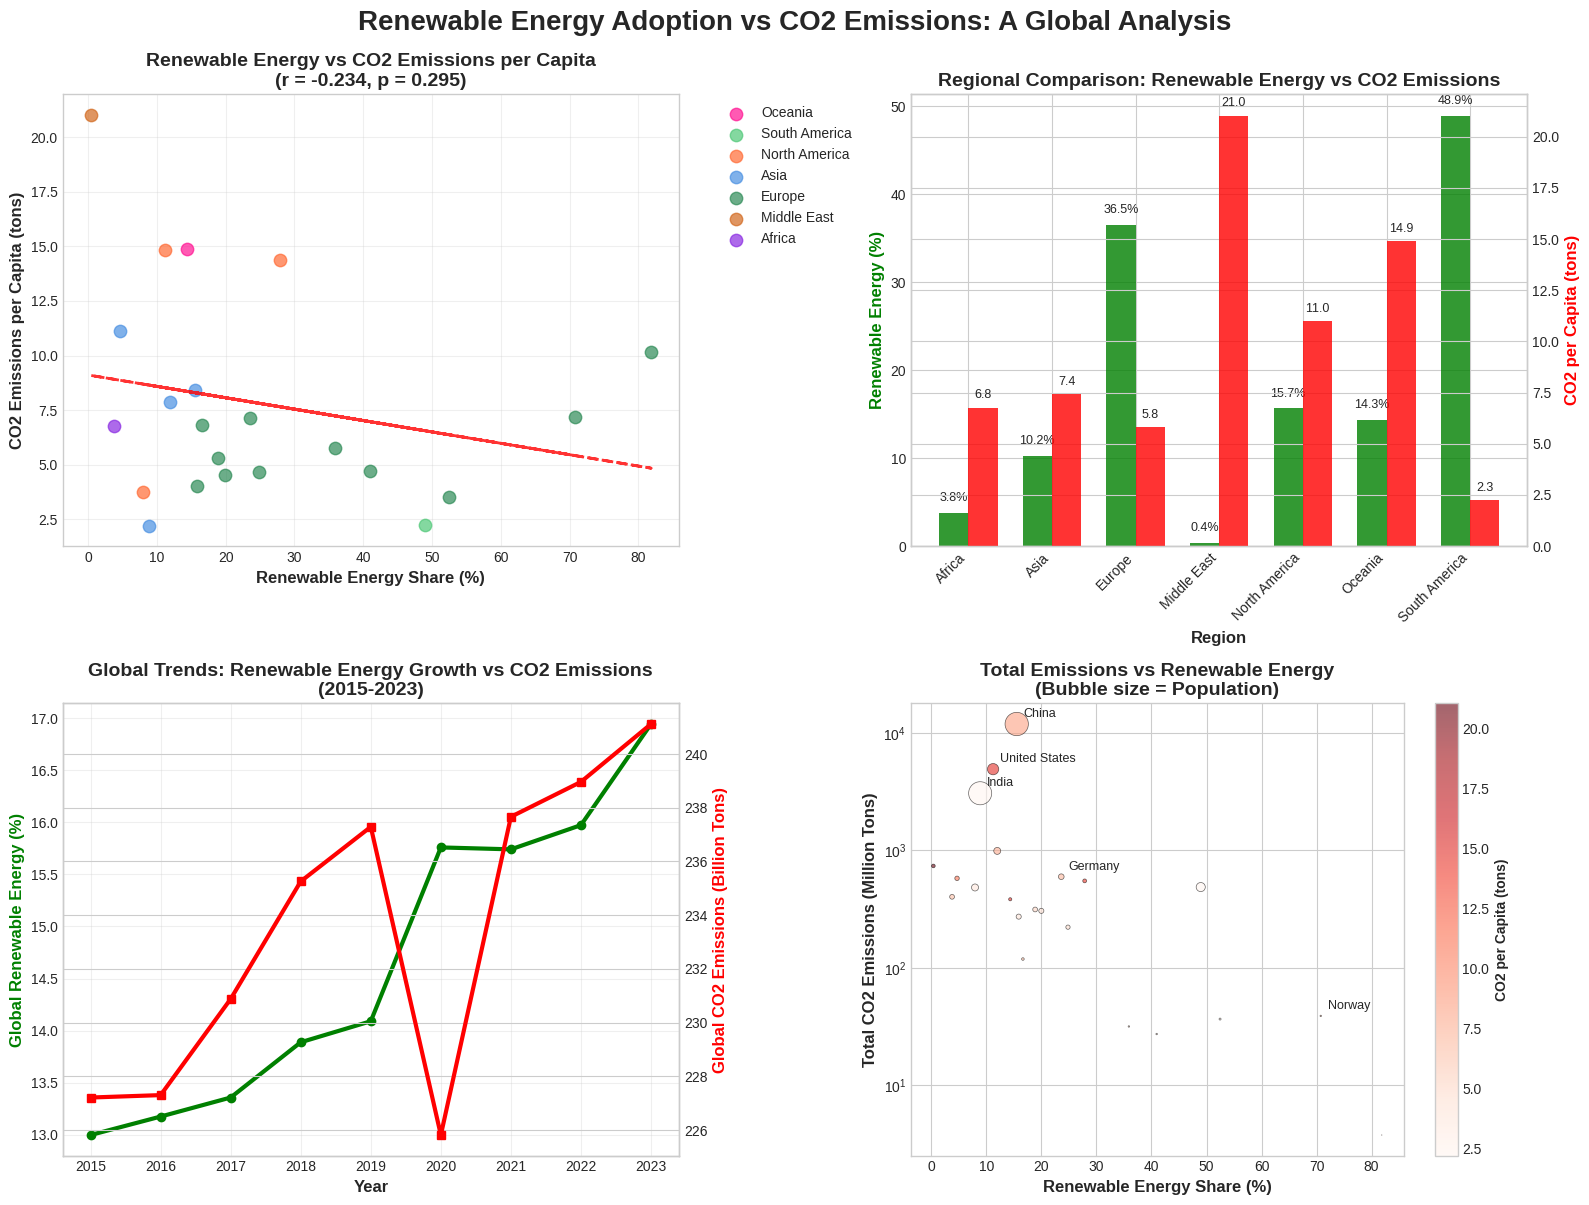

STATISTICAL ANALYSIS SUMMARY
Pearson correlation coefficient: -0.2336
Correlation strength: Weak negative correlation

REGIONAL ANALYSIS:
Oceania: 14.3% renewable, 14.9 tons CO2/capita
South America: 48.9% renewable, 2.3 tons CO2/capita
North America: 15.7% renewable, 11.0 tons CO2/capita
Asia: 10.2% renewable, 7.4 tons CO2/capita
Europe: 36.5% renewable, 5.8 tons CO2/capita
Middle East: 0.4% renewable, 21.0 tons CO2/capita
Africa: 3.8% renewable, 6.8 tons CO2/capita

TOP RENEWABLE PERFORMERS:
Iceland: 81.8% renewable, 10.2 tons CO2/capita
Norway: 70.8% renewable, 7.2 tons CO2/capita
Sweden: 52.5% renewable, 3.5 tons CO2/capita
Brazil: 48.9% renewable, 2.3 tons CO2/capita
Denmark: 40.9% renewable, 4.7 tons CO2/capita

HIGHEST CO2 EMITTERS (per capita):
Saudi Arabia: 0.4% renewable, 21.0 tons CO2/capita
Australia: 14.3% renewable, 14.9 tons CO2/capita
United States: 11.2% renewable, 14.8 tons CO2/capita
Canada: 27.9% renewable, 14.4 tons CO2/capita
South Korea: 4.7% renewable, 11.1 tons

In [3]:
# Set style for better aesthetics (Cairo's beauty principle)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Create the main visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Renewable Energy Adoption vs CO2 Emissions: A Global Analysis',
             fontsize=20, fontweight='bold', y=1)

# 1. Main Scatter Plot - Addresses the core research question
colors = {'Europe': '#2E8B57', 'North America': '#FF6B35', 'Asia': '#4A90E2',
          'South America': '#50C878', 'Middle East': '#D2691E', 'Africa': '#8A2BE2',
          'Oceania': '#FF1493'}

for region in df['Region'].unique():
    region_data = df[df['Region'] == region]
    ax1.scatter(region_data['Renewable_Percent'], region_data['CO2_Per_Capita'],
               c=colors[region], label=region, alpha=0.7, s=80)

# Add trend line and correlation
slope, intercept, r_value, p_value, std_err = stats.linregress(df['Renewable_Percent'], df['CO2_Per_Capita'])
line = slope * df['Renewable_Percent'] + intercept
ax1.plot(df['Renewable_Percent'], line, 'r--', alpha=0.8, linewidth=2)

ax1.set_xlabel('Renewable Energy Share (%)', fontsize=12, fontweight='bold')
ax1.set_ylabel('CO2 Emissions per Capita (tons)', fontsize=12, fontweight='bold')
ax1.set_title(f'Renewable Energy vs CO2 Emissions per Capita\n(r = {r_value:.3f}, p = {p_value:.3f})',
              fontsize=14, fontweight='bold')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# 2. Regional Analysis - Bar Chart
region_stats = df.groupby('Region').agg({
    'Renewable_Percent': 'mean',
    'CO2_Per_Capita': 'mean'
}).reset_index()

x_pos = np.arange(len(region_stats))
width = 0.35

bars1 = ax2.bar(x_pos - width/2, region_stats['Renewable_Percent'], width,
                label='Avg Renewable %', alpha=0.8, color='green')
ax2_twin = ax2.twinx()
bars2 = ax2_twin.bar(x_pos + width/2, region_stats['CO2_Per_Capita'], width,
                     label='Avg CO2 per Capita', alpha=0.8, color='red')

ax2.set_xlabel('Region', fontsize=12, fontweight='bold')
ax2.set_ylabel('Renewable Energy (%)', fontsize=12, fontweight='bold', color='green')
ax2_twin.set_ylabel('CO2 per Capita (tons)', fontsize=12, fontweight='bold', color='red')
ax2.set_title('Regional Comparison: Renewable Energy vs CO2 Emissions',
              fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(region_stats['Region'], rotation=45, ha='right')

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 1, f'{height:.1f}%',
             ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax2_twin.text(bar.get_x() + bar.get_width()/2., height + 0.3, f'{height:.1f}',
                  ha='center', va='bottom', fontsize=9)

# 3. Global Trends Over Time
ax3.plot(time_series_df['Year'], time_series_df['Global_Renewable_Percent'],
         marker='o', linewidth=3, markersize=6, color='green', label='Renewable Energy %')
ax3_twin = ax3.twinx()
ax3_twin.plot(time_series_df['Year'], time_series_df['Global_CO2_Billion_Tons'],
              marker='s', linewidth=3, markersize=6, color='red', label='Global CO2 Emissions')

ax3.set_xlabel('Year', fontsize=12, fontweight='bold')
ax3.set_ylabel('Global Renewable Energy (%)', fontsize=12, fontweight='bold', color='green')
ax3_twin.set_ylabel('Global CO2 Emissions (Billion Tons)', fontsize=12, fontweight='bold', color='red')
ax3.set_title('Global Trends: Renewable Energy Growth vs CO2 Emissions\n(2015-2023)',
              fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Add trend annotations
ax3.annotate('Renewable growth\nacceleration', xy=(2020, 12.1), xytext=(2017, 13),
             arrowprops=dict(arrowstyle='->', color='green'), fontsize=10)
ax3_twin.annotate('COVID-19\nimpact', xy=(2020, 36.3), xytext=(2018, 35),
                  arrowprops=dict(arrowstyle='->', color='red'), fontsize=10)

# 4. Population-weighted Analysis
df['Total_CO2'] = df['CO2_Per_Capita'] * df['Population_Millions']
bubble_sizes = df['Population_Millions'] / 5  # Scale for visibility

scatter = ax4.scatter(df['Renewable_Percent'], df['Total_CO2'],
                     s=bubble_sizes, alpha=0.6, c=df['CO2_Per_Capita'],
                     cmap='Reds', edgecolors='black', linewidth=0.5)

# Annotate key countries
key_countries = ['China', 'United States', 'India', 'Germany', 'Norway']
for country in key_countries:
    row = df[df['Country'] == country].iloc[0]
    ax4.annotate(country, (row['Renewable_Percent'], row['Total_CO2']),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

ax4.set_xlabel('Renewable Energy Share (%)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Total CO2 Emissions (Million Tons)', fontsize=12, fontweight='bold')
ax4.set_title('Total Emissions vs Renewable Energy\n(Bubble size = Population)',
              fontsize=14, fontweight='bold')
ax4.set_yscale('log')  # Log scale for better visualization of wide range

# Add colorbar for bubble chart
cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('CO2 per Capita (tons)', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

# Statistical Analysis and Summary
print("="*80)
print("STATISTICAL ANALYSIS SUMMARY")
print("="*80)

# Correlation analysis
correlation = df['Renewable_Percent'].corr(df['CO2_Per_Capita'])
print(f"Pearson correlation coefficient: {correlation:.4f}")
print(f"Correlation strength: {'Strong' if abs(correlation) > 0.7 else 'Moderate' if abs(correlation) > 0.3 else 'Weak'} negative correlation")

# Regional statistics
print(f"\nREGIONAL ANALYSIS:")
for region in df['Region'].unique():
    region_data = df[df['Region'] == region]
    avg_renewable = region_data['Renewable_Percent'].mean()
    avg_co2 = region_data['CO2_Per_Capita'].mean()
    print(f"{region}: {avg_renewable:.1f}% renewable, {avg_co2:.1f} tons CO2/capita")

# Top and bottom performers
print(f"\nTOP RENEWABLE PERFORMERS:")
top_renewable = df.nlargest(5, 'Renewable_Percent')[['Country', 'Renewable_Percent', 'CO2_Per_Capita']]
for _, row in top_renewable.iterrows():
    print(f"{row['Country']}: {row['Renewable_Percent']:.1f}% renewable, {row['CO2_Per_Capita']:.1f} tons CO2/capita")

print(f"\nHIGHEST CO2 EMITTERS (per capita):")
high_co2 = df.nlargest(5, 'CO2_Per_Capita')[['Country', 'Renewable_Percent', 'CO2_Per_Capita']]
for _, row in high_co2.iterrows():
    print(f"{row['Country']}: {row['Renewable_Percent']:.1f}% renewable, {row['CO2_Per_Capita']:.1f} tons CO2/capita")

print("="*80)
print("KEY INSIGHTS:")
print("1. There is a moderate negative correlation between renewable energy adoption and CO2 emissions")
print("2. Nordic countries demonstrate that high renewable energy can coexist with developed economies")
print("3. Regional patterns show Europe leading in renewable adoption")
print("4. Population size significantly impacts total emissions regardless of per capita efficiency")
print("="*80)